In [1]:
# Import libraries
# Common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Web scraping
import requests
from bs4 import BeautifulSoup
import json

# Merging names. Installation: pip install fuzzywuzzy and pip install fuzzywuzzy[speedup]
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from IPython.core import display as ICD

In [102]:
# epfl_en.json eth_en.json
epfl = pd.read_json(path_or_buf='epfl_en.json', orient=None, typ='frame', dtype=True, convert_axes=True,\
                    convert_dates=True, keep_default_dates=True, numpy=False, precise_float=False,\
                    date_unit=None, encoding=None, lines=False) 
epfl2=epfl.loc[epfl.id%10 == 3]
eth = pd.read_json('eth_en.json') 
eth2=eth.loc[eth.id%10 == 3]
epfl_ori = epfl.copy()
epfl2_ori = epfl2.copy()
eth_ori = eth.copy()
eth2_ori = eth2.copy()

In [140]:
print(len(epfl.columns))
cols1 = ['contributors', 'coordinates', 'created_at', 'entities',
       'extended_entities', 'favorite_count', 'favorited', 'geo', 'id',
       'id_str', 'in_reply_to_screen_name','in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id']
cols2 = ['in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place',
       'possibly_sensitive', 'quoted_status', 'quoted_status_id',
       'quoted_status_id_str', 'retweet_count', 'retweeted',
       'retweeted_status', 'source', 'text', 'truncated', 'user']
epfl[cols1].describe()
#epfl['favorite_count'].value_counts()

33


,contributors,favorite_count,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id
count,0.0,3208.000000,3.208000e+03,3.208000e+03,2.320000e+02,2.320000e+02,2.890000e+02
mean,NaN,1.192643,4.363864e+17,4.363864e+17,3.149188e+17,3.149188e+17,1.322358e+16
std,NaN,2.814000,2.471225e+17,2.471225e+17,1.336398e+17,1.336398e+17,9.984776e+16
min,NaN,0.000000,8.773885e+15,8.773885e+15,2.485129e+16,2.485129e+16,6.124730e+05
25%,NaN,0.000000,2.535212e+17,2.535212e+17,2.585621e+17,2.585621e+17,3.821793e+07
50%,NaN,0.000000,3.983257e+17,3.983257e+17,2.770714e+17,2.770714e+17,1.551840e+08
75%,NaN,1.000000,6.728088e+17,6.728088e+17,3.095519e+17,3.095519e+17,4.857176e+08
max,NaN,31.000000,8.246758e+17,8.246758e+17,8.108852e+17,8.108852e+17,7.742841e+17


We see that contributors, coordinates, geo,  are almost always null (or non existant), so we get rid of them:

In [106]:
def my_drop_cols(df):
    to_drop=['id_str', 'extended_entities','contributors','coordinates','geo']+\
            ['entities','source','truncated','filter_level','matching_rules']
    if set(to_drop).issubset(df.columns):
        df.drop(to_drop,axis=1,inplace=True)
    else:
        print('Not droped')
    return df
    
#epfl = my_drop_cols(epfl)

print(epfl.columns)
epfl.head()

Index(['contributors', 'coordinates', 'created_at', 'entities',
       'extended_entities', 'favorite_count', 'favorited', 'geo', 'id',
       'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place',
       'possibly_sensitive', 'quoted_status', 'quoted_status_id',
       'quoted_status_id_str', 'retweet_count', 'retweeted',
       'retweeted_status', 'source', 'text', 'truncated', 'user'],
      dtype='object')


,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
0,NaN,None,2017-01-26 17:50:03,"{'symbols': [], 'user_mentions': [{'id': 24710...",NaN,0,False,None,824675783063048195,824675783063048192,...,NaN,NaN,NaN,5,False,"{'contributors': None, 'truncated': False, 'te...","<a href=""http://bufferapp.com"" rel=""nofollow"">...",RT @TechXplore_com: Reptilian robots are spies...,False,"{'follow_request_sent': False, 'has_extended_p..."
1,NaN,None,2017-01-26 16:45:16,"{'symbols': [], 'user_mentions': [{'id': 17248...",NaN,0,False,None,824659481678270465,824659481678270464,...,NaN,NaN,NaN,42,False,"{'contributors': None, 'truncated': False, 'te...","<a href=""http://bufferapp.com"" rel=""nofollow"">...",RT @physorg_com: Astronomers measure #universe...,False,"{'follow_request_sent': False, 'has_extended_p..."
2,NaN,None,2017-01-26 15:44:53,"{'symbols': [], 'user_mentions': [{'id': 23822...",NaN,0,False,None,824644286486638593,824644286486638592,...,NaN,NaN,NaN,4,False,"{'contributors': None, 'truncated': True, 'tex...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @MartinVetterli: Robotic Reptiles by @epfl_...,False,"{'follow_request_sent': False, 'has_extended_p..."
3,NaN,None,2017-01-26 13:00:41,"{'symbols': [], 'user_mentions': [{'id': 25769...","{'media': [{'source_user_id': 2576923915, 'sou...",0,False,None,824602965394788352,824602965394788352,...,NaN,NaN,NaN,3,False,"{'contributors': None, 'truncated': False, 'te...","<a href=""http://bufferapp.com"" rel=""nofollow"">...",RT @TechnologistEU: Three months in the #Antar...,False,"{'follow_request_sent': False, 'has_extended_p..."
4,NaN,None,2017-01-26 12:15:06,"{'symbols': [], 'user_mentions': [{'id': 24409...",NaN,0,False,None,824591492861874177,824591492861874176,...,NaN,NaN,NaN,3,False,"{'contributors': None, 'truncated': False, 'te...","<a href=""http://bufferapp.com"" rel=""nofollow"">...",RT @_hsanctuary: A fun @EPFL_en report on robo...,False,"{'follow_request_sent': False, 'has_extended_p..."


In [107]:
def add_date_columns(df):
    col = df['created_at']
    df['created_at']=df['created_at'].apply(lambda d: pd.to_datetime(d))
    df['Year'] = [date.year for date in col] 
    df['Month'] = [date.month for date in col] 
    df['Day'] = [date.day for date in col] 
    df['Hour'] = [date.hour for date in col] 
    return df
epfl = add_date_columns(epfl)
epfl[['created_at','Year','Month','Day','Hour']].head(3)
eth = add_date_columns(eth)
eth[['created_at','Year','Month','Day','Hour']].head(3)


,created_at,Year,Month,Day,Hour
0,2017-01-27 17:00:13,2017,1,27,17
1,2017-01-27 14:23:41,2017,1,27,14
2,2017-01-26 14:56:07,2017,1,26,14


UTC times


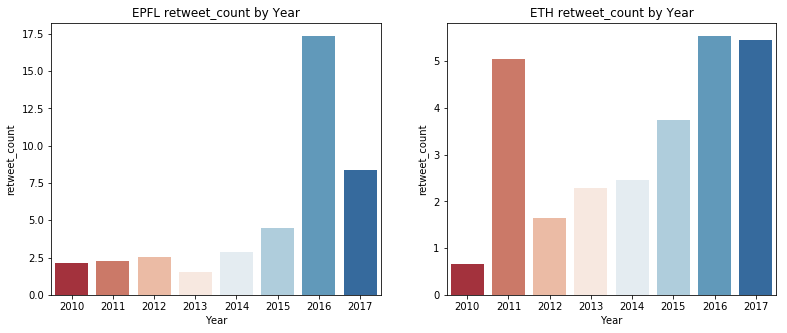

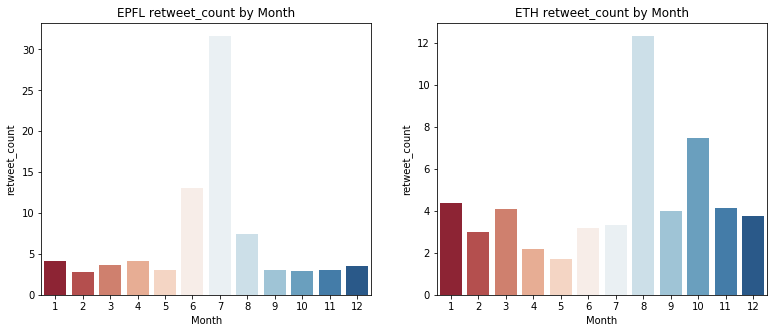

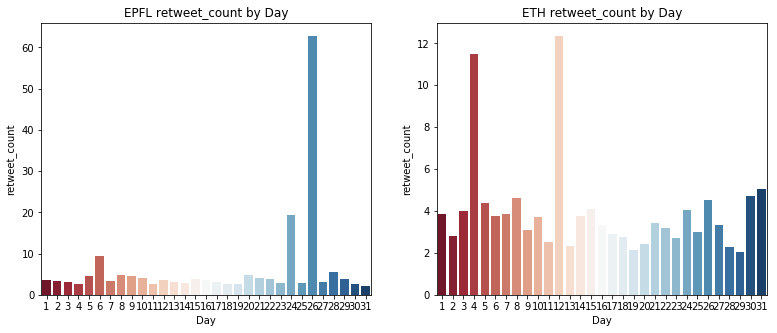

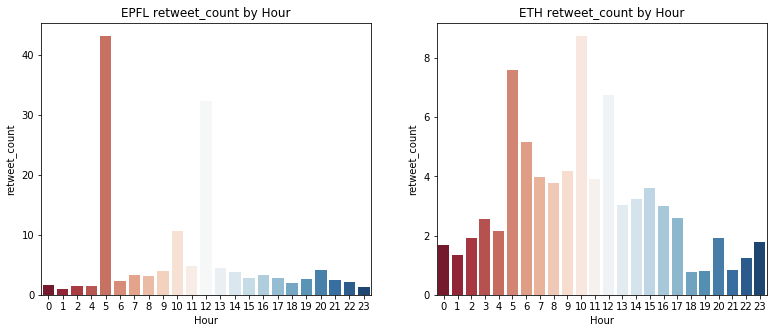

In [131]:
def descriptive_plot1(x_col,y_col, less_tick=False):
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(13, 5))
    ax1.set_title('EPFL '+y_col+' by '+x_col)
    # New cases plot
    sns.factorplot(x=x_col,y=y_col,hue=None, data=epfl, kind="bar", ci=None,\
                       palette='RdBu',legend=True, margin_titles=True,ax=ax1) # hue is how many bars per tick
    plt.close()

    ax2.set_title('ETH '+y_col+' by '+x_col)
    sns.factorplot(x=x_col,y=y_col,hue=None, data=eth, kind="bar", ci=None,\
                       palette='RdBu',legend=True, margin_titles=False,ax=ax2) # hue is how many bars per tick
    plt.close()

descriptive_plot1(x_col='Year',y_col='retweet_count')

descriptive_plot1(x_col='Month',y_col='retweet_count')
descriptive_plot1(x_col='Day',y_col='retweet_count')
print ('UTC times')
descriptive_plot1(x_col='Hour',y_col='retweet_count')

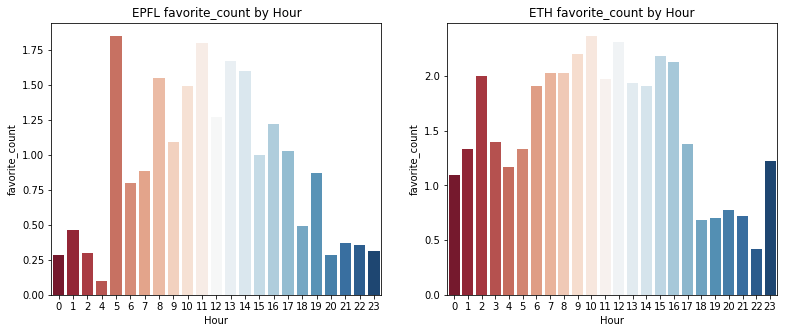

In [132]:
descriptive_plot1(x_col='Hour',y_col='favorite_count')

EPFL has less retweets w.r.t. ETH 

In [ ]:
epfl.loc[1]['entities']['hashtags'][0]['text']

In [159]:
def add_hashtags(x):
    if len(x['hashtags']) == 0:
        return []
    else:
        out = []
        #out.append(x['entities']['hashtags'][0]['text'])
        for hashtag in x['hashtags']:
            out.append(hashtag['text'])
        return out
    
#add_hashtags(epfl.loc[1]) 
hashtags = epfl['entities'].apply(add_hashtags)

epfl['hashtags'] = pd.Series(hashtags)



In [303]:
epfl['hashtags_count'] =  pd.Series(hashtags).apply(len)
epfl['hashtags_count'].head()

0    0
1    2
2    1
3    2
4    0
Name: hashtags_count, dtype: int64

In [160]:
epfl['hashtags'].head()

0                        []
1    [universe, newphysics]
2                  [biorob]
3      [Antarctic, climate]
4                        []
Name: hashtags, dtype: object

In [161]:
all_hash = []
for x in hashtags:
    if len(x)>0:
        for y in x:
            all_hash.append(y)

In [185]:
most_used_hash = pd.Series(all_hash).value_counts().head(10)
tmp = list(most_used_hash.index)
most_used_hash

EPFL               133
ScienceQuestion     66
epfl                62
aaasmtg             42
epflENAC            39
epflSV              37
epflSB              34
AAASmtg             29
epflSTI             28
startup             28
dtype: int64

In [224]:
any(('startup' in s for s in epfl['hashtags']))

True

In [ ]:
def x_in_y(x,y):

    df.apply
    def group_public_transportation(x):
    return x['NB_BUS']+x['NB_TRAM']

In [268]:

def retweets_by_hashtags(df, hashtags_list):
    for d in hashtags_list:
        def hash_in_tweet_retweet_count(x):
            if len(x['hashtags'])==0:
                return 0
            else:
                if d in x['hashtags']:
                    return 1
                else:
                    return 0

        def hash_in_tweet(x):
            if len(x['hashtags'])==0:
                return 0
            else:
                if d in x['hashtags']:
                    return x['retweet_count']
                else:
                    return 0

        count = df.apply(hash_in_tweet,axis=1).sum() 
        retweets = df.apply(hash_in_tweet_retweet_count,axis=1).sum()
        d_mean = retweets/count
        print(str(d)+'   mean retweets: ' + str(d_mean))
        
        
retweets_by_hashtags(epfl,tmp)

EPFL   mean retweets: 0.4634146341463415
ScienceQuestion   mean retweets: 0.36464088397790057
epfl   mean retweets: 0.5849056603773585
aaasmtg   mean retweets: 2.3333333333333335
epflENAC   mean retweets: 0.2846715328467153
epflSV   mean retweets: 0.20786516853932585
epflSB   mean retweets: 0.288135593220339
AAASmtg   mean retweets: 0.6590909090909091
epflSTI   mean retweets: 0.20437956204379562
startup   mean retweets: 0.4666666666666667


AAASmtg is the best, however we should aggregate by same names using word matching!

In [247]:
epfl.loc[1]['hashtags']

['universe', 'newphysics']

In [230]:
d='startup'
for d in tmp:
    def hash_in_tweet(x):
        if (d in s for s in x['hashtags']):
            return x['retweet_count']
        else:
            return 0
    d_mean = epfl.apply(hash_in_tweet,axis=1).mean()
    print(str(d)+'   mean retweets: ' + str(d_mean))

EPFL   mean retweets: 6.120324189526184
ScienceQuestion   mean retweets: 6.120324189526184
epfl   mean retweets: 6.120324189526184
aaasmtg   mean retweets: 6.120324189526184
epflENAC   mean retweets: 6.120324189526184
epflSV   mean retweets: 6.120324189526184
epflSB   mean retweets: 6.120324189526184
AAASmtg   mean retweets: 6.120324189526184
epflSTI   mean retweets: 6.120324189526184
startup   mean retweets: 6.120324189526184


In [222]:
epfl.loc[('startup' in s for s in epfl['hashtags'])]

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,text,truncated,user,Year,Month,Day,Hour,hashtags,prediction,propensity score
0,NaN,None,2017-01-26 17:50:03,"{'symbols': [], 'user_mentions': [{'id': 24710...",NaN,0,False,None,824675783063048195,824675783063048192,...,RT @TechXplore_com: Reptilian robots are spies...,False,"{'follow_request_sent': False, 'has_extended_p...",2017,1,26,17,[],0,0.218995
0,NaN,None,2017-01-26 17:50:03,"{'symbols': [], 'user_mentions': [{'id': 24710...",NaN,0,False,None,824675783063048195,824675783063048192,...,RT @TechXplore_com: Reptilian robots are spies...,False,"{'follow_request_sent': False, 'has_extended_p...",2017,1,26,17,[],0,0.218995
0,NaN,None,2017-01-26 17:50:03,"{'symbols': [], 'user_mentions': [{'id': 24710...",NaN,0,False,None,824675783063048195,824675783063048192,...,RT @TechXplore_com: Reptilian robots are spies...,False,"{'follow_request_sent': False, 'has_extended_p...",2017,1,26,17,[],0,0.218995
0,NaN,None,2017-01-26 17:50:03,"{'symbols': [], 'user_mentions': [{'id': 24710...",NaN,0,False,None,824675783063048195,824675783063048192,...,RT @TechXplore_com: Reptilian robots are spies...,False,"{'follow_request_sent': False, 'has_extended_p...",2017,1,26,17,[],0,0.218995
0,NaN,None,2017-01-26 17:50:03,"{'symbols': [], 'user_mentions': [{'id': 24710...",NaN,0,False,None,824675783063048195,824675783063048192,...,RT @TechXplore_com: Reptilian robots are spies...,False,"{'follow_request_sent': False, 'has_extended_p...",2017,1,26,17,[],0,0.218995
0,NaN,None,2017-01-26 17:50:03,"{'symbols': [], 'user_mentions': [{'id': 24710...",NaN,0,False,None,824675783063048195,824675783063048192,...,RT @TechXplore_com: Reptilian robots are spies...,False,"{'follow_request_sent': False, 'has_extended_p...",2017,1,26,17,[],0,0.218995
0,NaN,None,2017-01-26 17:50:03,"{'symbols': [], 'user_mentions': [{'id': 24710...",NaN,0,False,None,824675783063048195,824675783063048192,...,RT @TechXplore_com: Reptilian robots are spies...,False,"{'follow_request_sent': False, 'has_extended_p...",2017,1,26,17,[],0,0.218995
0,NaN,None,2017-01-26 17:50:03,"{'symbols': [], 'user_mentions': [{'id': 24710...",NaN,0,False,None,824675783063048195,824675783063048192,...,RT @TechXplore_com: Reptilian robots are spies...,False,"{'follow_request_sent': False, 'has_extended_p...",2017,1,26,17,[],0,0.218995
0,NaN,None,2017-01-26 17:50:03,"{'symbols': [], 'user_mentions': [{'id': 24710...",NaN,0,False,None,824675783063048195,824675783063048192,...,RT @TechXplore_com: Reptilian robots are spies...,False,"{'follow_request_sent': False, 'has_extended_p...",2017,1,26,17,[],0,0.218995
0,NaN,None,2017-01-26 17:50:03,"{'symbols': [], 'user_mentions': [{'id': 24710...",NaN,0,False,None,824675783063048195,824675783063048192,...,RT @TechXplore_com: Reptilian robots are spies...,False,"{'follow_request_sent': False, 'has_extended_p...",2017,1,26,17,[],0,0.218995


In [220]:
for x in tmp:
    x_mean = epfl.loc[(x in s for s in epfl['hashtags'])]['retweet_count'].mean()
    print(str(x)+'   mean retweets: ' + str(x_mean))

EPFL   mean retweets: 6.5339775561097255
ScienceQuestion   mean retweets: 5.761221945137157
epfl   mean retweets: 5.715087281795511
aaasmtg   mean retweets: 5.484413965087282
epflENAC   mean retweets: 5.449812967581047
epflSV   mean retweets: 5.426745635910224
epflSB   mean retweets: 5.39214463840399
AAASmtg   mean retweets: 5.3344763092269325
epflSTI   mean retweets: 5.322942643391521
startup   mean retweets: 5.322942643391521


# some plots

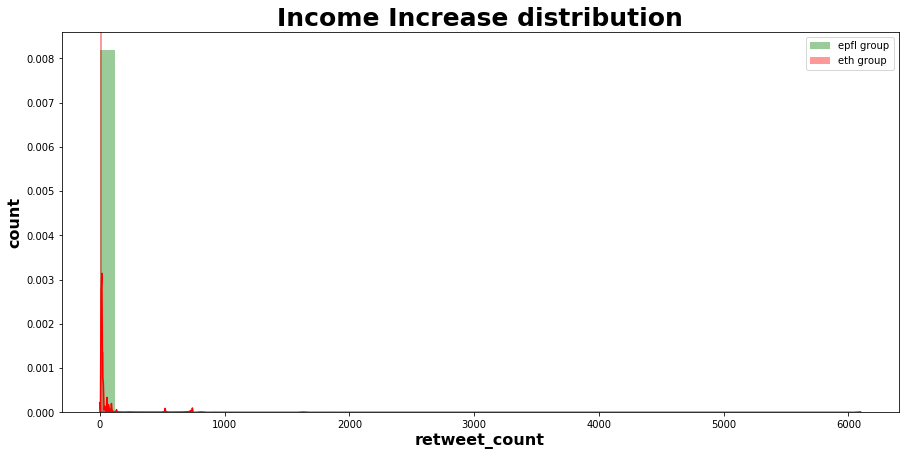

In [396]:
f, ax = plt.subplots(figsize=(15,7))
sns.distplot(epfl['retweet_count'], kde=True, color="g", ax = ax, label = 'epfl group')
ax.set_ylabel('count', fontsize=16).set_weight('bold')
ax.set_xlabel('Income increase', fontsize=16).set_weight('bold')
sns.distplot(eth['retweet_count'], kde=True, color="r", ax = ax, label = 'eth group')
plt.title("Income Increase distribution", fontsize=25).set_weight('bold')
ax.legend()

,contributors,favorite_count,favorited,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,...,truncated,Year,Month,Day,Hour,prediction,propensity score,hashtags_count,lang_float,user_followers
contributors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
favorite_count,NaN,1.000000,0.069882,0.377282,0.377282,0.349149,0.349149,0.247579,0.247579,0.045527,...,0.236055,0.371232,0.049148,-0.024969,-0.037562,NaN,-0.029519,-0.023976,0.023800,NaN
favorited,NaN,0.069882,1.000000,0.014542,0.014542,0.106853,0.106853,-0.011075,-0.011075,-0.005019,...,-0.005547,0.012907,0.009398,0.011421,0.011876,NaN,-0.011427,-0.032902,-0.020203,NaN
id,NaN,0.377282,0.014542,1.000000,1.000000,0.999995,0.999995,0.376026,0.376026,0.120818,...,0.162278,0.986781,0.110616,-0.037044,-0.088954,NaN,-0.072764,0.071926,0.041299,NaN
id_str,NaN,0.377282,0.014542,1.000000,1.000000,0.999995,0.999995,0.376026,0.376026,0.120818,...,0.162278,0.986781,0.110616,-0.037044,-0.088954,NaN,-0.072764,0.071926,0.041299,NaN


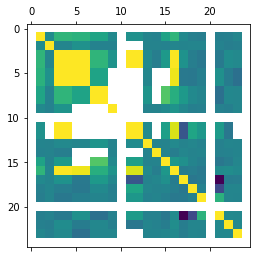

In [399]:
plt.matshow(epfl.corr())
epfl.corr().head()

# Linear Regression

In [391]:
pfl = epfl.copy()
th = eth.copy()
#epfl_tmp.loc[epfl_tmp['lang_float']==0].set_index('lang_float',append=True)
#epfl_tmp.loc[0]['entities']
pd.concat([pfl,th],axis=0).shape

(5309, 39)

In [380]:
epfl.columns
epfl.loc[0]['user']['followers_count']


21447

In [372]:
epfl.lang.value_counts()
def lang_to_float(x):
    if x=='en':
        return 1
    else:
        return 0
def get_user_followers_count(x):
    return x['followers_count']
epfl['lang_float'] = epfl.lang.apply(lang_to_float)
epfl['user_followers'] = epfl.user.apply(get_user_followers_count)

In [373]:
# Import ML library
from sklearn import linear_model, cross_validation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

df=epfl
# Build a regressor
model = linear_model.LinearRegression()

# Create feature matrix and prediction vector
feature_cols = ['Day', 'Year', 'Month', 'Hour','favorited','favorite_count','retweeted',\
               'hashtags_count','lang_float','user_followers']
X = df[feature_cols]
y = df['retweet_count']

# Split training, testing and validation tests
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.8) # 80% train
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=0, train_size=0.5) # 10% test, 10% validation

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [379]:
# train it
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [375]:
# First Evaluation
print ('Initial score:')
print('Train score:',model.score(X_train, y_train))#, scoring='neg_mean_absolute_error'))

Initial score:
Train score: 0.00297962739876


In [376]:
print('Test score:',model.score(X_test, y_test))
print('Validation score:',str(model.score(X_val, y_val)))

Test score: -1.04601854628
Validation score: -0.96364943559


In [377]:
scores = cross_validation.cross_val_score(model, X, y, cv=3, scoring= 'neg_mean_absolute_error')
scores.mean()

-9.6302421832244232

Which is not a good prediction ^^

In [324]:
predicted = cross_val_predict(model, X, y, cv=10)

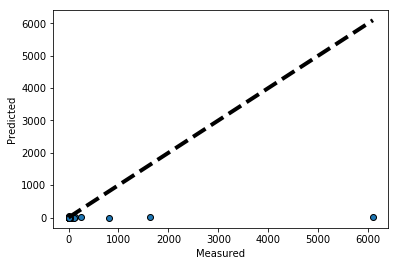

In [325]:
fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

We could have train on all the tweets and the specialized our model just on EPFL and ETH datasets

# Topic modelling


In [326]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from pprint import pprint
from time import time
import itertools
from pandas.io.json import json_normalize
from pathlib import Path 
import os 
import pickle

In [328]:
# Vectorize the text dataset
vectorizer = TfidfVectorizer(max_features=10000,\
                             max_df=0.7,\
                             strip_accents = 'ascii',
                             stop_words='english')
vectors = vectorizer.fit_transform(epfl.text)
vectors.shape

(3208, 10000)

In [346]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000
documents = eth.text
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [347]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 5

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [348]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx) )
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
              )

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
http eth zurich new prof congrats bit ly research scientists
Topic 1:
https eth eth2cal cybathlon amp research new 2016 ethzurich zurich
Topic 2:
rt ethzukunftsblog eth_en asks blogs swissnexsf diplocourier writes futuritynews http
Topic 3:
ethz zhny resilientcities amp nurturinggenius complexsystems cities bigdata risk urban
Topic 4:
researchers developed eth cells created mechanism time discovered method http
Topic 0:
http eth rt new eth_en https amp future data tedxzurich
Topic 1:
eth http https zurich rt research bit ly university world
Topic 2:
https eth http rt researchers new ethzukunftsblog zurich amp prof
Topic 3:
ethz zhny resilientcities cities complex amp systems complexsystems risk dirk
Topic 4:
bit ly eth2cal 15 possible strategic 2011 featured process making
